# Linear Neural Networks

This notebook is a note for myself to summarize my understanding of linear regression after reading d2l book and my prior experience in deep learning.

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Linear Model

Linear regression is a method to model the linear relationship between a set of independent variables (noted as $\mathbf{x}$) and one dependent variable (noted as $y$). The general formula is shown below.

$$\hat{y} = \mathbf{w}^{T} \mathbf{x} + b$$

In [6]:
def get_weights(n_feat):
    '''define the linear model'''
    w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    return w, b

def linear_regression(x, w, b):
    '''linear regression operation'''
    return x @ w + b

$\mathbf{w}$ are weights and b is the bias. Weights are responsible for assigning the relative importance of the corresponding features, while the bias gives a predicted value when all features are set 0 (if we normalize the features, it may imply the expectation, or you may also think of it as the addition of the expressiveness of the model, from a linear transformatiioin to affine transformation)

Many mapping may not be as easy as linear, even though the underlying mapping is indeed linear, due to some noises like measurement errors, we may not be able to come up with a model that fits the training data perfectly.

Until now, all we are talking about is the model itself -- the architecture. Besides that, we will need to have a searching algorithm to help us find the parameters of the model  ($\mathbf{w}$ and $b$) that could best fit the traininig data.

we will have several choices to have those parameters, the most naive way is the exhaustively search for all possible combiniations of parameters, from -n to n with a step size of n. Another way, and the way we will adopt, is to take advantage of calculus: finding the gradient of the weights with respect to the loss, and change the parameters corresponding to the direction of the gradients.

## Loss Function

Before we are heading to find the best fit parameters, we need to first define a loss function which measures the goodness and badness of our current predictions.

Loss function is chosen to be l2 as shown below (1/2 is for the ease of derivative). Intuitively, we need a distance metric the define to measure the deviation between the predicted values and the groundtruth values. To our best knowledge, mean sqaured distance (aka L2) or mean absolute distance (aka L1) may have a good try just like what we may use them in Euclidean space. Mathematically, minimizing the MSE (mean square error -- L2) is the maximum likelihood estimation of a linear model under the assumptino of additive Gaussian noise.

$$L2(\mathbf{w}, b) = \sum^{N}_{n=1} \frac{1}{2} (\hat{y}_n - y_n)^2$$

In [7]:
def l2_loss(y_hat, y):
    '''l2 loss function'''
    return ((y_hat-y)**2)/2

## Learning algorithm

Learning algorithm is to find the better parameters of the model based on the current evalution. Gradient descent is the norm to use in deep learning: update the parameters of the model in a way that all of them go in the opposite direction of the gradients with respect to the loss. The step size, $\eta$, of each update is uniform to all parameters in the naive gradient descent algorithm, and is called as 'learning rate'.

$$w = w - \eta * \frac{\partial L2}{\partial w}$$

$$b = b - \eta * \frac{\partial L2}{\partial b}$$

Gradient Descent was to update the parameters after calculating the loss of the entire dataset, but it is found that if we update the parameters once a small batch of the training data (like 32 samples), the training process can be largely accelerated and able to achieve better accuracy. This method is called as Minibatch Stochastic Gradient Descent (SGD), and is the norm to use in deep learning.

In [8]:
def sgd(params, lr, batchsize):
    '''stochastic gradient descent'''
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batchsize
            param.grad.zero_()

## Get some data

To test the effectiveness of our model, we will train our model on a synthesized data ($y = wX + b + noise$). Then we can compare the $w$ ad $b$ between the groundtruth and trained easily.

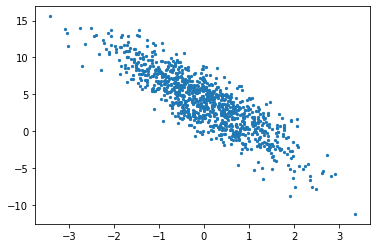

In [9]:
def get_syn_data(w, b, n_samples):
    '''y = Xw + b + noise'''
    X = torch.normal(0, 1, (n_samples, len(w)))
    y = X @ w + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape(-1, 1)

true_w = torch.tensor([2, -3.4])
true_b = 4.2
feats, labels = get_syn_data(true_w, true_b, 1000)
plt.scatter(feats[:, 1], labels, s=5)

In [13]:
def get_minibatch(batchsize, feats, labels, shuffle=True):
    '''
    get the minibatch of training data each time. support shuffling 
    return a iterable with the number of batchsize for each iterations
    '''
    n_samples = len(labels)
    indices = list(range(n_samples))
    if shuffle:
        np.random.shuffle(indices)
    for i in range(0, n_samples, batchsize):
        batch_indices = torch.tensor(
            indices[i: min(i+batchsize, n_samples)]) # integer multiple of the batchsize may not equal the len of the training data
        yield feats[batch_indices], labels[batch_indices]

In [14]:
# show the minibatch in one iteration
print(next(get_minibatch(8, feats, labels)))

(tensor([[ 0.0371, -0.5514],
        [ 1.4824,  1.2214],
        [ 1.8764,  0.9964],
        [ 0.2627,  1.2105],
        [ 0.2642,  0.5085],
        [ 0.0619,  0.7252],
        [ 0.1295, -0.0413],
        [ 0.1341, -0.5284]]), tensor([[6.1532],
        [2.9948],
        [4.5663],
        [0.6042],
        [2.9989],
        [1.8651],
        [4.5993],
        [6.2439]]))


## Train and Evaluation

In [52]:
lr = 0.03
n_epochs = 3
batchsize = 10
net = linear_regression
loss_fn = l2_loss


# get data
true_w = torch.tensor([2, -3.4]) # groundtruth weights
true_b = 4.2 # groundtruth bias
feats, labels = get_syn_data(true_w, true_b, 1000)

#get weights
w, b = get_weights(2)

#train
for epoch in range(n_epochs):
    for x, y in get_minibatch(batchsize, feats, labels):
        y_hat = net(x, w, b) # prediction
        loss = loss_fn(y_hat, y).sum() # calculate the loss
        loss.backward() # backprop
        sgd([w, b], lr, batchsize) # update the parameters
    with torch.no_grad():
        train_loss = loss_fn(net(feats, w, b),  labels)
        print(f'epoch{epoch+1}: loss={train_loss.mean()}, w={w}, b={b}')

TypeError: 'SGD' object is not callable

## Use pytorch package to accelerate the development

In [68]:
# dataloader
dataset = torch.utils.data.TensorDataset(feats, labels)
loader = torch.utils.data.DataLoader(dataset, batchsize, shuffle=True)

next(iter(loader))

[tensor([[-2.1117, -0.5734],
         [ 0.0749, -1.2362],
         [-1.0050,  1.7148],
         [-1.2528,  0.0157],
         [ 0.3871,  1.6418],
         [ 0.3696, -0.3955],
         [-0.1156, -0.3967],
         [ 0.1984,  0.9117],
         [ 0.4609, -0.3388],
         [ 0.6239,  0.3212]]),
 tensor([[ 1.9096],
         [ 8.5433],
         [-3.6379],
         [ 1.6524],
         [-0.6054],
         [ 6.3050],
         [ 5.2967],
         [ 1.5227],
         [ 6.2688],
         [ 4.3629]])]

In [77]:
# loss
loss_fn = torch.nn.MSELoss()

# net
net = torch.nn.Sequential(torch.nn.Linear(2, 1))
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

list(net.parameters())

[Parameter containing:
 tensor([[-0.0129,  0.0076]], requires_grad=True),
 Parameter containing:
 tensor([0.], requires_grad=True)]

In [78]:
# optim
sgd = torch.optim.SGD(net.parameters(), lr=0.03)

In [79]:
#train
for epoch in range(n_epochs):
    for x, y in loader:
        y_hat = net(x) # prediction
        loss = loss_fn(y_hat, y) # calculate the loss
        sgd.zero_grad()
        loss.backward() # backprop
        sgd.step() # update the parameters
    train_loss = loss_fn(net(feats),  labels)
    print(f'epoch{epoch+1}: loss={train_loss.mean()}, w={net[0].weight}, b={net[0].bias}')

epoch1: loss=0.00014416527119465172, w=Parameter containing:
tensor([[ 2.0014, -3.3966]], requires_grad=True), b=Parameter containing:
tensor([4.1945], requires_grad=True)
epoch2: loss=0.0001017114773276262, w=Parameter containing:
tensor([[ 2.0008, -3.3995]], requires_grad=True), b=Parameter containing:
tensor([4.1998], requires_grad=True)
epoch3: loss=0.00010335531987948343, w=Parameter containing:
tensor([[ 2.0018, -3.4001]], requires_grad=True), b=Parameter containing:
tensor([4.2002], requires_grad=True)
